In this notebook we simulate hard rhombic dodecahedra using the [HPMC component](https://hoomd-blue.readthedocs.io/en/stable/package-hpmc.html) of HOOMD-Blue. We visualize the shapes using the [fresnel backend](https://fresnel.readthedocs.io/en/stable/) and color them by their [Steinhardt](https://freud.readthedocs.io/en/stable/order.html#freud.order.LocalQlNear) $Q_6$ order parameter.

In [1]:
import flowws
import gtar
from hoomd_flowws.Init import Init
from hoomd_flowws.RunHPMC import RunHPMC
from hoomd_flowws.ShapeDefinition import ShapeDefinition

import json
import plato, plato.draw.fresnel as draw
import freud
import numpy as np
import IPython
import ipywidgets

In [2]:
shape = dict(type='icosahedron', modifications=[dict(type='scale', factor=2)])

storage = flowws.DirectoryStorage()
stages = [
    ShapeDefinition(shape_arguments=[shape]),
    Init(number=128),
    RunHPMC(steps=1e5, integrator='npt', box_move_length=(.05, 1), dump_period=1e3),
]

flowws.Workflow(stages, storage, dict(hoomd_context_args='--mode=cpu')).run();

HOOMD-blue v2.9.3 CUDA (11.1) DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 10/19/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
-----
You are using DEM. Please cite the following:
* M Spellings, R L Marson, J A Anderson, and S C Glotzer. "GPU accelerated
  Discrete Element Method (DEM) molecular dynamics for conservative, faceted
  particle simulations",  Journal of Computational Physics 334 (2017) 460--467
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created 

In [3]:
num_frames = 0

def get_frame(frame=-1):
    global num_frames
    with gtar.GTAR('dump.sqlite', 'r') as traj:
        (posRec, quatRec, boxRec), frames = traj.framesWithRecordsNamed(['position', 'orientation', 'box'])

        for (_, type_shapes) in traj.recordsNamed('type_shapes.json'):
            type_shapes = json.loads(type_shapes)

        num_frames = len(frames)
        positions = traj.getRecord(posRec, frames[frame])
        orientations = traj.getRecord(quatRec, frames[frame])
        box = traj.getRecord(boxRec, frames[frame])

    shapedef = type_shapes[0]
    return positions, orientations, box, shapedef

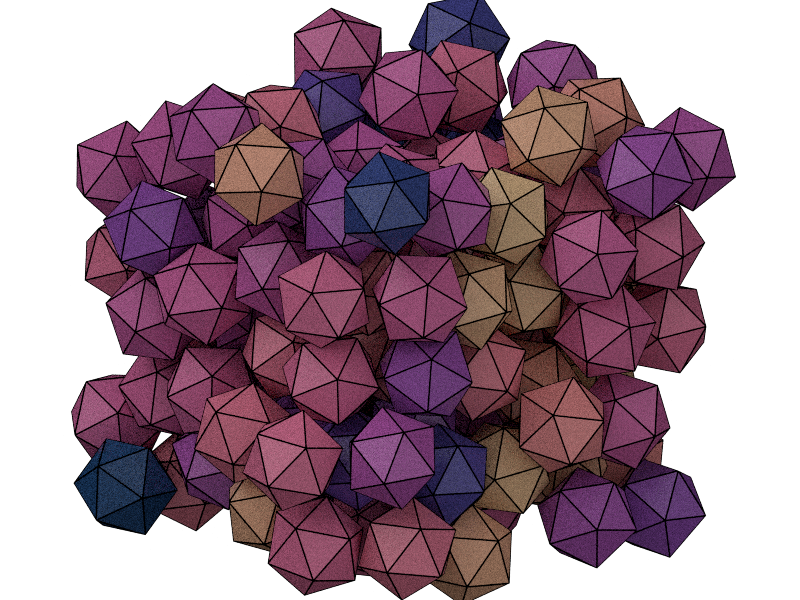

In [4]:
def update(scene, frame=-1):
    (positions, orientations, box, shapedef) = get_frame(frame)
    # get Steinhardt q6, rescaled from 0 to 1, as cval
    fbox = freud.box.Box.from_box(box)
    q6 = freud.order.Steinhardt(6)
    q6.compute((fbox, positions), neighbors=dict(num_neighbors=12))
    cval = q6.particle_order.copy()
    cval -= np.min(cval)
    cval /= np.max(cval)

    colors = plato.cmap.cubehelix(.25 + .5*cval, s=2)

    for prim in scene:
        prim.positions = positions
        prim.orientations = orientations
        prim.colors = colors
        prim.vertices = shapedef['vertices']

prim = draw.ConvexPolyhedra(outline=.025)
features = dict(pathtracer=dict(samples=128))
scene = draw.Scene(prim, zoom=1.8, features=features,
                   rotation=[0.94183356, 0.15549502, 0.29752356, 0.01583402])
update(scene)

target = '../../gallery/flowws_icosahedra_fresnel.png'
scene.save(target)
IPython.display.Image(filename=target)

In [5]:
import plato.draw.vispy as interactive

live_scene = scene.convert(interactive)
live_scene.show()

@ipywidgets.interact(frame=(0, num_frames - 1))
def plot(frame=0):
    update(live_scene, frame)
    live_scene.render()

VispyWidget(height=600, width=800)

interactive(children=(IntSlider(value=0, description='frame', max=99), Output()), _dom_classes=('widget-intera…